# Analyze all signals at once 

- **Step 1: Libraries & Data Loading**  
First, we import the necessary libraries (pandas for data handling, matplotlib for plotting) and load the CSV file. We also calculate the Heart Rate (BPM) since it's not explicitly in the CSV.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def load_and_prepare_data(csv_path):
    """
    Loads the CSV file, parses dates, and calculates Heart Rate (BPM).
    """
    print("Loading data...")
    df = pd.read_csv(csv_path)

    # Convert string timestamps to Python datetime objects
    # 'coerce' handles any parsing errors gracefully
    df['t_dt'] = pd.to_datetime(df['t_dt'], errors='coerce')

    # Calculate Heart Rate (BPM) from RR interval
    # Formula: BPM = 60,000 ms / RR_interval_ms
    df['BPM'] = 60000.0 / df['RR_prev_ms']
    
    print(f"Data loaded. Total beats: {len(df)}")
    return df

- **Step 2: Data Cleaning & Smoothing**    
Raw ECG data is noisy. In this step, we remove physiologically impossible values (e.g., BPM > 180 or QTc > 1000ms) and apply a "Rolling Average" to see the clear trend lines instead of noise.

In [10]:
def clean_and_smooth_metrics(df):
    """
    Filters outliers and calculates moving averages for trends.
    """
    # --- 1. Heart Rate (BPM) ---
    # Keep realistic BPM values between 30 and 180
    bpm_df = df[(df['BPM'] >= 30) & (df['BPM'] <= 180)].copy()
    
    # Calculate 5-minute Moving Average (approx 400 beats)
    # This creates the smooth blue line in the plot
    bpm_df['BPM_Trend'] = bpm_df['BPM'].rolling(window=400, min_periods=50).mean()

    # --- 2. QTc Interval ---
    # Drop rows where QT calculation failed (NaN)
    qt_df = df.dropna(subset=['QTc_Bazett_ms', 'QTc_Fridericia_ms']).copy()
    
    # Filter realistic QTc range (300ms - 1000ms)
    qt_df = qt_df[(qt_df['QTc_Bazett_ms'] > 300) & (qt_df['QTc_Bazett_ms'] < 1000)]
    
    # Calculate Moving Average for QTc (Window: 50 beats)
    qt_df['QTc_Bazett_MA'] = qt_df['QTc_Bazett_ms'].rolling(window=50, min_periods=10).mean()
    qt_df['QTc_Fridericia_MA'] = qt_df['QTc_Fridericia_ms'].rolling(window=50, min_periods=10).mean()

    # --- 3. QRS Duration ---
    # Filter stable QRS range
    qrs_df = df[(df['QRS_ms'] > 50) & (df['QRS_ms'] < 200)].copy()
    qrs_df['QRS_Trend'] = qrs_df['QRS_ms'].rolling(window=400, min_periods=50).mean()
    
    return bpm_df, qt_df, qrs_df

- **Step 3: Visualization**    
This function creates the main 3-panel chart (Heart Rate, QTc, QRS). It handles the layout, colors, and time formatting on the x-axis.

In [11]:
def plot_full_analysis(bpm_df, qt_df, qrs_df, output_file="ecg_analysis_report.png"):
    """
    Generates a 3-panel plot showing BPM, QTc, and QRS trends over time.
    """
    # Create a figure with 3 subplots sharing the X-axis
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

    # --- Panel 1: Heart Rate ---
    # Plot raw data points (light gray)
    ax1.scatter(bpm_df['t_dt'], bpm_df['BPM'], color='lightgray', s=2, alpha=0.5, label='Instant BPM')
    # Plot trend line (blue)
    ax1.plot(bpm_df['t_dt'], bpm_df['BPM_Trend'], color='blue', linewidth=2, label='Trend (Avg)')
    # Add threshold line (120 BPM limit)
    ax1.axhline(y=120, color='red', linestyle='--', alpha=0.5, label='Algorithm Limit (120)')
    
    ax1.set_ylabel('Heart Rate (BPM)')
    ax1.set_title('Heart Rate Trends', fontsize=14)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # --- Panel 2: QTc Interval ---
    # Plot raw points
    ax2.scatter(qt_df['t_dt'], qt_df['QTc_Bazett_ms'], color='lightgray', s=2, alpha=0.5)
    # Plot Bazett Trend (Purple)
    ax2.plot(qt_df['t_dt'], qt_df['QTc_Bazett_MA'], color='purple', linewidth=2, label='QTc (Bazett)')
    # Plot Fridericia Trend (Green)
    ax2.plot(qt_df['t_dt'], qt_df['QTc_Fridericia_MA'], color='green', linewidth=2, label='QTc (Fridericia)')
    
    ax2.set_ylabel('QTc Duration (ms)')
    ax2.set_title('QTc Interval Changes (Drug Effect Monitoring)', fontsize=14)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(500, 900) # Focus on relevant range

    # --- Panel 3: QRS Duration ---
    # Plot QRS Trend (Orange)
    ax3.plot(qrs_df['t_dt'], qrs_df['QRS_Trend'], color='orange', linewidth=2, label='QRS Duration')
    
    ax3.set_ylabel('QRS (ms)')
    ax3.set_xlabel('Time of Day')
    ax3.set_title('Signal Stability Check (QRS Width)', fontsize=14)
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)

    # --- Formatting X-Axis (Time) ---
    # Show time as Hour:Minute (e.g., 14:30)
    date_form = mdates.DateFormatter("%H:%M")
    ax3.xaxis.set_major_formatter(date_form)
    ax3.xaxis.set_major_locator(mdates.HourLocator(interval=1)) # Tick every 1 hour
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    print(f"Plot saved to {output_file}")

- **Step 4: Main Execution**

Loading data...
Data loaded. Total beats: 24853
Plot saved to Final_Report_Graph.png


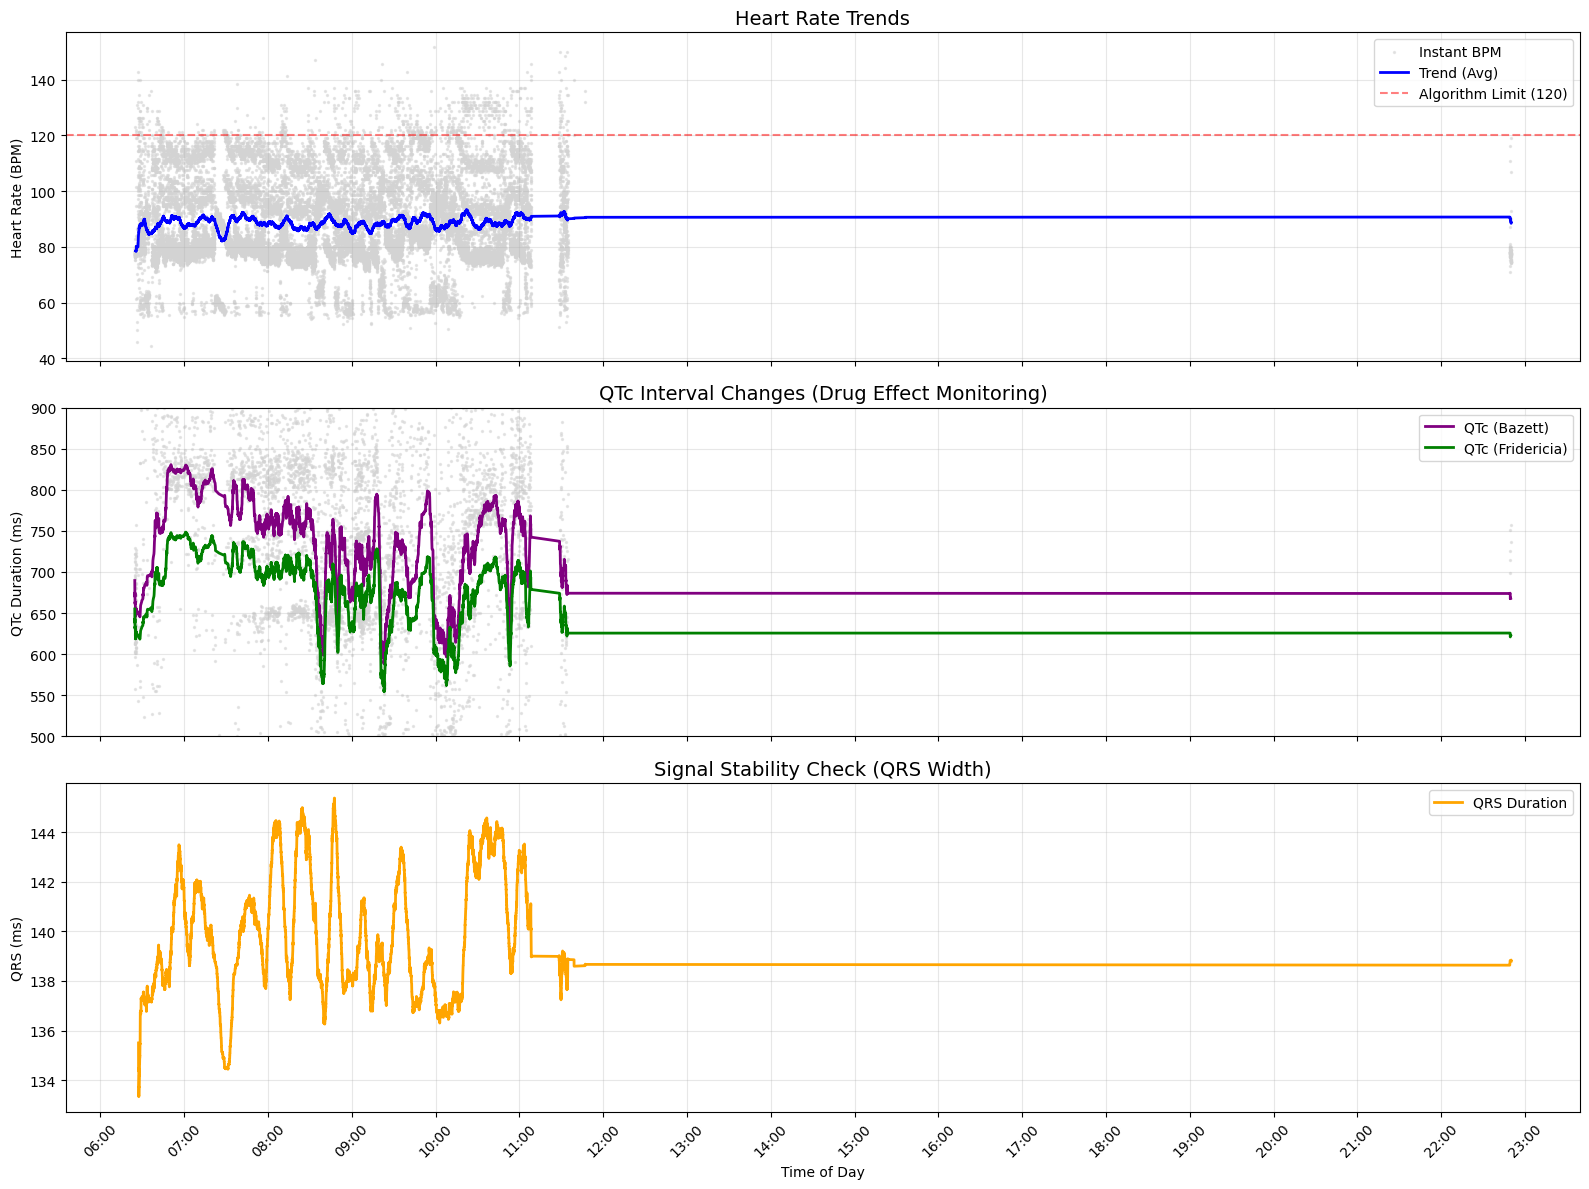

In [13]:
if __name__ == "__main__":
    # 1. Define file path
    csv_file = "ecg_output_3254689660/per_beat_metrics.csv"
    
    # 2. Load Data
    try:
        df = load_and_prepare_data(csv_file)
        
        # 3. Process Data
        bpm_data, qt_data, qrs_data = clean_and_smooth_metrics(df)
        
        # 4. Plot Data
        # You can change the output filename here
        plot_full_analysis(bpm_data, qt_data, qrs_data, output_file="Final_Report_Graph.png")
        
    except FileNotFoundError:
        print("Error: per_beat_metrics.csv not found. Please run the analysis script first.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Code for analyze spesific part 

Loading ecg_output_3254689660/per_beat_metrics.csv...
Data filtered. Found 2558 beats in the selected window.
Zoomed plot saved to Zoomed_Analysis_Report.png


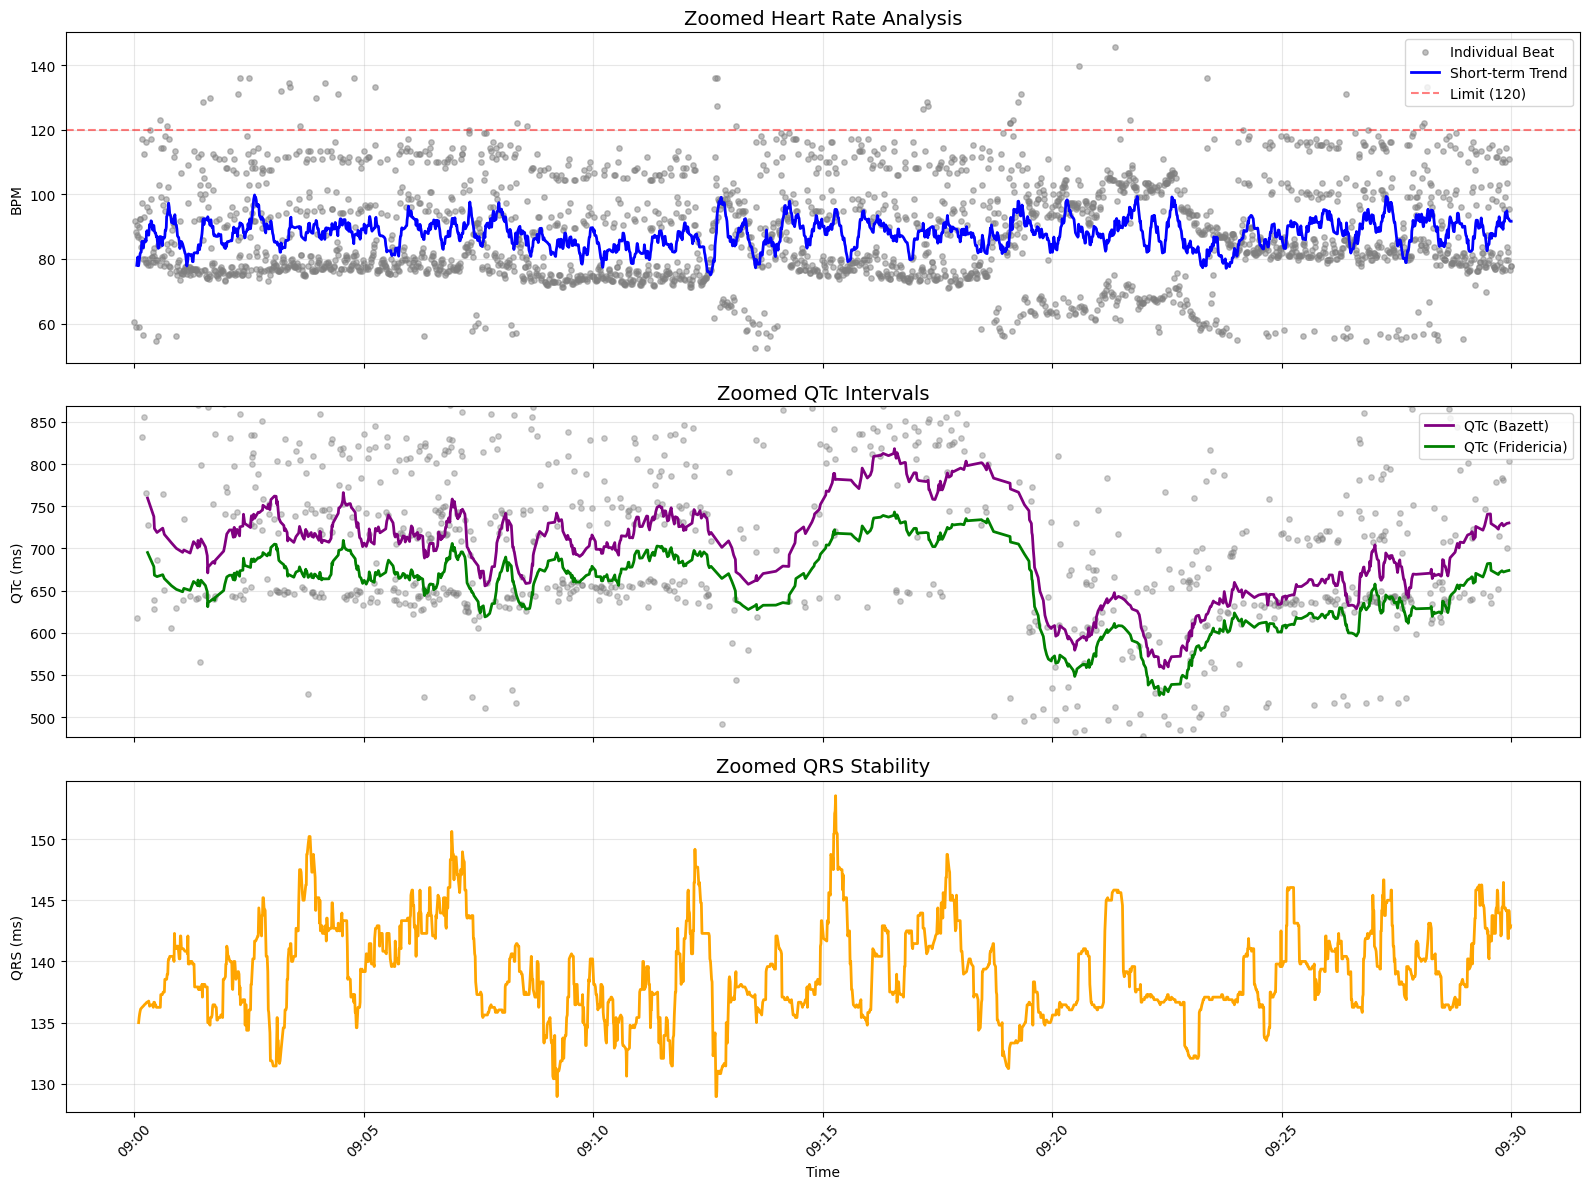

In [15]:
# analyze_zoom.py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# ==========================================
# USER CONFIGURATION (AYARLAR)
# ==========================================
# Enter the start and end time you want to examine closely.
# Format: "YYYY-MM-DD HH:MM:SS"
# Make sure these times are within the valid range (06:24 - 11:45 for your file).

ZOOM_START = "2019-06-06 09:00:00"
ZOOM_END   = "2019-06-06 09:30:00" 

CSV_FILE   = "ecg_output_3254689660/per_beat_metrics.csv"
OUTPUT_IMG = "Zoomed_Analysis_Report.png"

# ==========================================
# MAIN SCRIPT
# ==========================================

def load_and_filter_data(csv_path, start_str, end_str):
    """
    Loads the CSV and filters it to the specific time range.
    """
    print(f"Loading {csv_path}...")
    df = pd.read_csv(csv_path)
    
    # Parse datetime column
    df['t_dt'] = pd.to_datetime(df['t_dt'], errors='coerce')
    
    # Calculate BPM
    df['BPM'] = 60000.0 / df['RR_prev_ms']
    
    # Convert string inputs to datetime objects
    t_start = pd.to_datetime(start_str)
    t_end = pd.to_datetime(end_str)
    
    # Filter the dataframe
    mask = (df['t_dt'] >= t_start) & (df['t_dt'] <= t_end)
    df_subset = df.loc[mask].copy()
    
    if df_subset.empty:
        print("Error: No data found in this time range!")
        print(f"Check your timestamps. Valid data is likely between 06:24 and 11:45.")
        return None
        
    print(f"Data filtered. Found {len(df_subset)} beats in the selected window.")
    return df_subset

def calculate_zoomed_metrics(df):
    """
    Calculates metrics with a smaller rolling window for detailed viewing.
    """
    # Since we are zoomed in, we use a smaller window for smoothing
    # (e.g., 20 beats instead of 400) to see faster changes.
    short_window = 20 
    
    # 1. BPM
    # Filter noise (30-180 BPM)
    bpm_df = df[(df['BPM'] >= 30) & (df['BPM'] <= 180)].copy()
    bpm_df['BPM_Trend'] = bpm_df['BPM'].rolling(window=short_window, min_periods=5).mean()

    # 2. QTc
    qt_df = df.dropna(subset=['QTc_Bazett_ms', 'QTc_Fridericia_ms']).copy()
    # Filter realistic QTc
    qt_df = qt_df[(qt_df['QTc_Bazett_ms'] > 300) & (qt_df['QTc_Bazett_ms'] < 1000)]
    qt_df['QTc_Bazett_MA'] = qt_df['QTc_Bazett_ms'].rolling(window=short_window, min_periods=5).mean()
    qt_df['QTc_Fridericia_MA'] = qt_df['QTc_Fridericia_ms'].rolling(window=short_window, min_periods=5).mean()

    # 3. QRS
    qrs_df = df[(df['QRS_ms'] > 50) & (df['QRS_ms'] < 200)].copy()
    qrs_df['QRS_Trend'] = qrs_df['QRS_ms'].rolling(window=short_window, min_periods=5).mean()
    
    return bpm_df, qt_df, qrs_df

def plot_zoomed_analysis(bpm_df, qt_df, qrs_df, output_file):
    """
    Plots the data with markers to see individual beats.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

    # --- Panel 1: BPM ---
    # s=15 makes the dots bigger so you can see every single heartbeat
    ax1.scatter(bpm_df['t_dt'], bpm_df['BPM'], color='gray', s=15, alpha=0.5, label='Individual Beat')
    ax1.plot(bpm_df['t_dt'], bpm_df['BPM_Trend'], color='blue', linewidth=2, label='Short-term Trend')
    ax1.axhline(y=120, color='red', linestyle='--', alpha=0.5, label='Limit (120)')
    
    ax1.set_ylabel('BPM')
    ax1.set_title('Zoomed Heart Rate Analysis', fontsize=14)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # --- Panel 2: QTc ---
    ax2.scatter(qt_df['t_dt'], qt_df['QTc_Bazett_ms'], color='gray', s=15, alpha=0.4)
    ax2.plot(qt_df['t_dt'], qt_df['QTc_Bazett_MA'], color='purple', linewidth=2, label='QTc (Bazett)')
    ax2.plot(qt_df['t_dt'], qt_df['QTc_Fridericia_MA'], color='green', linewidth=2, label='QTc (Fridericia)')
    
    ax2.set_ylabel('QTc (ms)')
    ax2.set_title('Zoomed QTc Intervals', fontsize=14)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    # Auto-scale Y-axis for zoom
    if not qt_df.empty:
        y_min = qt_df['QTc_Fridericia_MA'].min() - 50
        y_max = qt_df['QTc_Bazett_MA'].max() + 50
        ax2.set_ylim(max(0, y_min), min(1000, y_max))

    # --- Panel 3: QRS ---
    ax3.plot(qrs_df['t_dt'], qrs_df['QRS_Trend'], color='orange', linewidth=2, label='QRS Duration')
    ax3.set_ylabel('QRS (ms)')
    ax3.set_xlabel('Time')
    ax3.set_title('Zoomed QRS Stability', fontsize=14)
    ax3.grid(True, alpha=0.3)

    # Format X-Axis to show Hours:Minutes
    date_form = mdates.DateFormatter("%H:%M")
    ax3.xaxis.set_major_formatter(date_form)
    ax3.xaxis.set_major_locator(mdates.MinuteLocator(interval=5)) # Tick every 5 minutes
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    print(f"Zoomed plot saved to {output_file}")

if __name__ == "__main__":
    try:
        # 1. Load subset
        df_subset = load_and_filter_data(CSV_FILE, ZOOM_START, ZOOM_END)
        
        if df_subset is not None:
            # 2. Calculate metrics
            bpm, qt, qrs = calculate_zoomed_metrics(df_subset)
            
            # 3. Plot
            plot_zoomed_analysis(bpm, qt, qrs, OUTPUT_IMG)
            
    except FileNotFoundError:
        print(f"Error: {CSV_FILE} not found.")
    except Exception as e:
        print(f"An error occurred: {e}")